## Imports

In [1]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import calendar

In [2]:
df = pd.read_csv("./Data/cleaned_govtrades.csv")
df["Estimated Holdings"] = df["Estimated Holdings"].str[1:].str.replace(",", "")
df["Estimated Holdings"] = df["Estimated Holdings"].astype(int)
df["Party"] = df["Senator"].str[-5]
df["State"] = df["Senator"].str[-3:-1]
df_lawsuits = pd.read_csv("../Private Data/cleaned_stanford.csv")
df_combined = pd.read_csv("../Private Data/cleaned_combined_data.csv")

df_govtrades = df[df["Estimated Holdings"]>0]
df_combined = df_combined[df_combined["Estimated Holdings"]>0]

## GovTrades Analysis

### Which Sectors have Senators invested in?

In [3]:
def getSumCount(df, group_col, agg_col):
    grouped_holdings = df.groupby(group_col).agg({agg_col: ["sum", "count"]}).reset_index()
    grouped_holdings.columns = [' '.join(col).strip() for col in grouped_holdings.columns.values]
    return grouped_holdings

In [4]:
sector_holdings = getSumCount(df_govtrades, "Sector", "Estimated Holdings")

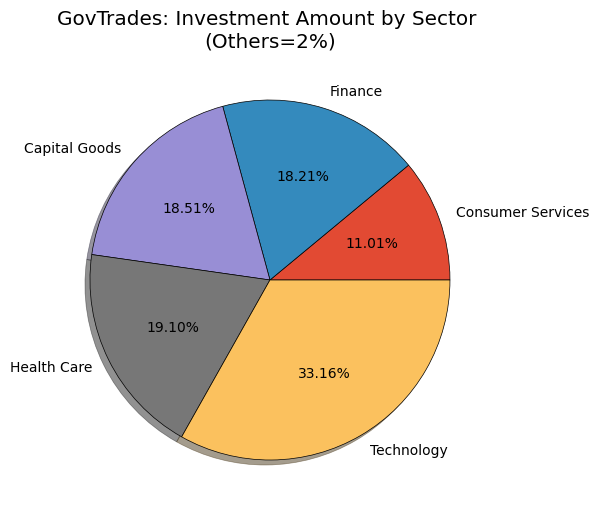

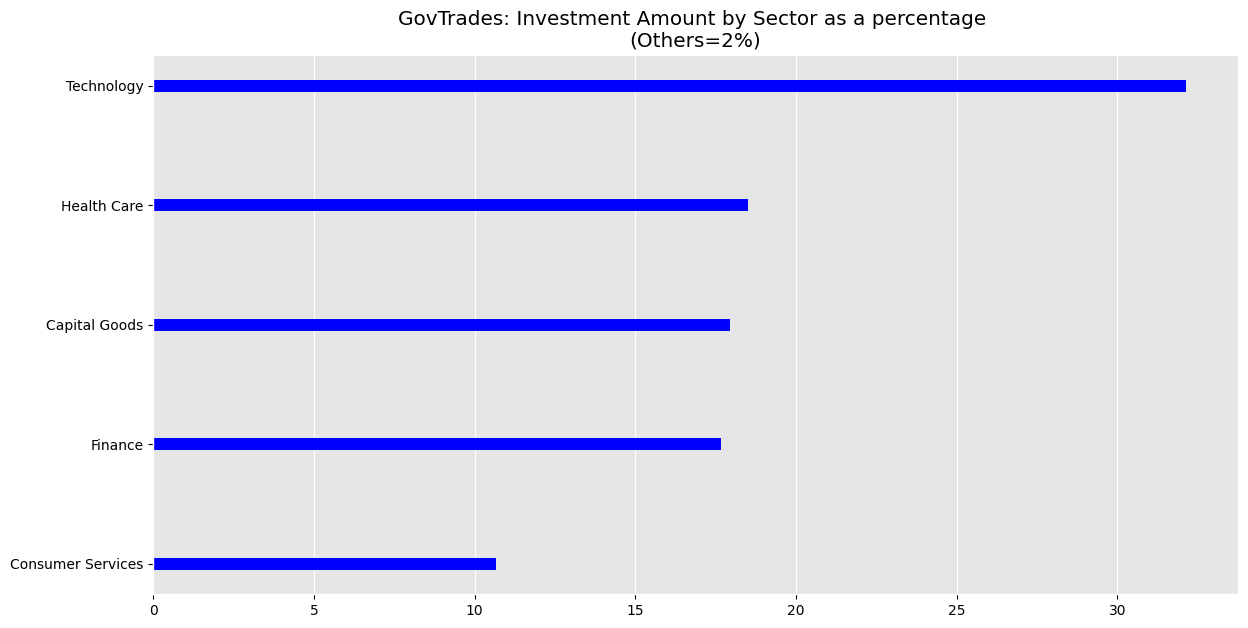

In [5]:
scale = 1e5
pie_sector_data = sector_holdings["Estimated Holdings sum"]/scale
pie_sector_data /= pie_sector_data.sum()
pie_sector_data *= 100
indices = pie_sector_data>2
indices = pie_sector_data[indices].sort_values().index

with plt.style.context('ggplot'):
    _ = plt.pie(pie_sector_data[indices], labels = sector_holdings["Sector"][indices]
                , wedgeprops={"edgecolor": "black"}, autopct="%1.2f%%"
                , shadow=True)
    plt.tight_layout()
    plt.title("GovTrades: Investment Amount by Sector \n(Others=2%)")
    plt.show()
plt.close()
# https://scc.ms.unimelb.edu.au/resources/data-visualisation-and-exploration/no_pie-charts

with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(14, 7))
    plt.barh(sector_holdings["Sector"][indices], pie_sector_data[indices],
            color="blue", height=0.1, capstyle="round")
    plt.grid(False)
    plt.title("GovTrades: Investment Amount by Sector as a percentage \n(Others=2%)")
    ax = plt.gca()
    ax.xaxis.grid(True)
    ax.tick_params(axis='both', colors='black')
    plt.show()
plt.close()

### How does sector investment vary based on the Senator's Party?

In [6]:
df_govtrades.groupby("Party").sum("Estimated Holdings")/1e6

,Estimated Holdings
Party,
D,242.3199
R,188.4699


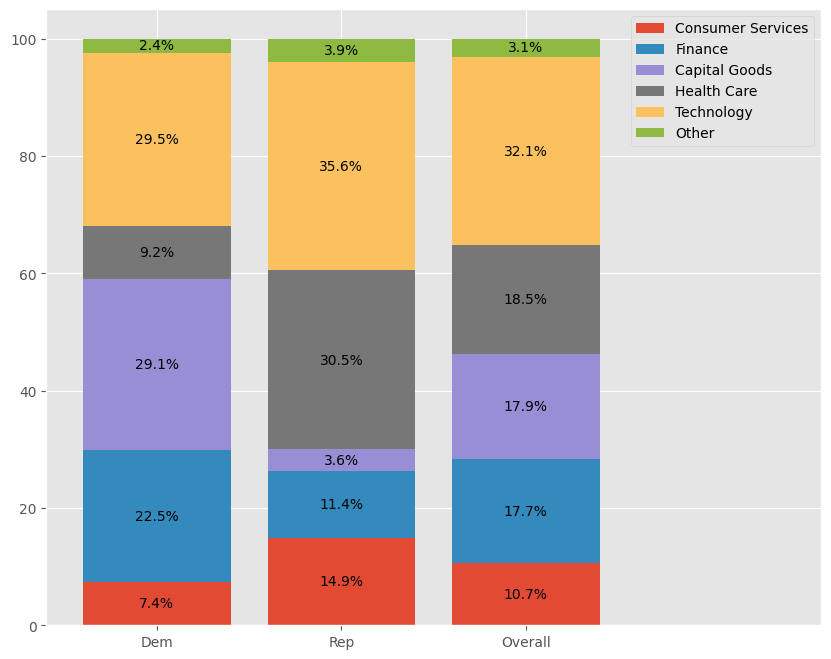

In [7]:
pie_sector_data = sector_holdings["Estimated Holdings sum"]/scale
pie_sector_data /= pie_sector_data.sum()
indices = pie_sector_data>0.02
indices = pie_sector_data[indices].sort_values().index
party_percentages = pd.DataFrame(index=[])
total_percentages = pd.Series()
for id in indices:
    sector = sector_holdings["Sector"][id]
    data = df_govtrades[df_govtrades["Sector"]==sector].groupby('Party').sum("Estimated Holdings").reset_index()
    party_percentages[sector] = data["Estimated Holdings"].astype(np.float64)
    total_percentages[sector] = pie_sector_data[id]
party_percentages.index = ["Dem","Rep"]
party_totals = df_govtrades.groupby('Party').sum("Estimated Holdings").reset_index()['Estimated Holdings']
party_percentages.loc["Dem"] /= party_totals.iloc[0]
party_percentages.loc["Rep"] /= party_totals.iloc[1]
party_percentages.loc["Overall"] = total_percentages
party_percentages["Other"] = 1-np.sum(party_percentages,axis=1)

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(10,8))
    bottom = np.zeros(3)

    for sector in party_percentages.columns:
        percentages = party_percentages[sector]*100

        p = ax.bar(party_percentages.index,percentages,width=0.8,label=sector,bottom=bottom)

        bottom += percentages
        ax.bar_label(p, labels=[f'{p:.1f}%' for p in percentages], label_type='center')

    ax.legend()
    plt.xlim([-0.6,3.6])
    plt.show()
plt.close()

### How does Estimated Investment depend on the State the Senator is from?

In [8]:
state_holdings = df_govtrades.groupby('State')['Estimated Holdings'].sum().reset_index()

In [9]:
scale = 1e5
fig = go.Figure(data=[
    go.Scattergeo(
    locationmode='USA-states',
    locations=state_holdings['State'],
    text=(state_holdings['Estimated Holdings']/scale).round(2),
    showlegend=False,
    marker=dict(
        size=state_holdings['Estimated Holdings'] / scale,
        color='skyblue',
        line=dict(width=1, color='DarkSlateGray'),
        sizemode='area',
        )

    ),
    go.Scattergeo(
        locationmode='USA-states',
        locations=state_holdings['State'],
        text=state_holdings['State'],  # State names near states
        mode='text',
        textposition='top left',  # State names above bubbles
        showlegend=False, #prevent legend from showing up.
    )
    ]
)

fig.update_layout(
    title_text='Estimated Holdings by State (where the Senator is from)',
    geo=dict(
        scope='usa',
        # projection_type='albers usa',
        # showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    )
)
fig.show()
plt.close()

### How  diversified are Senators' investements by Party?

In [10]:
df_senator_count_total = df_govtrades.groupby(["Senator"])["Company"].nunique().reset_index()
df_senator_count_total.sort_values("Company", ascending=False)
df_senator_count_total.columns = ["Senator", "Count"]
df_senator_count_total["Party"] = df_senator_count_total["Senator"].str[-5]

In [11]:
# df_govtrades[df_govtrades["Senator"]=="Tom Carper (D-DE)"]['Company'].value_counts().index.tolist()

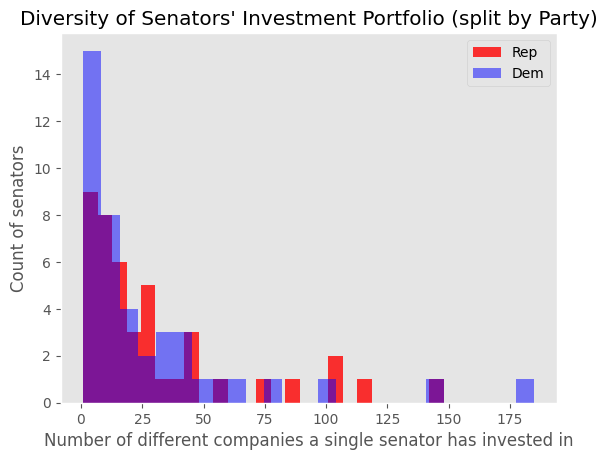

In [12]:
with plt.style.context('ggplot'):
    ra= plt.hist(df_senator_count_total[df_senator_count_total["Party"]=="R"]["Count"], histtype="bar", alpha=0.8, color="red", label="Rep", bins=25)
    da= plt.hist(df_senator_count_total[df_senator_count_total["Party"]=="D"]["Count"], histtype="bar", alpha=0.5, color="blue", label="Dem", bins=25)
    plt.legend()
    plt.grid(False)
    plt.title("Diversity of Senators' Investment Portfolio (split by Party)")
    plt.xlabel("Number of different companies a single senator has invested in")
    plt.ylabel('Count of senators')
    plt.show()
    plt.close()

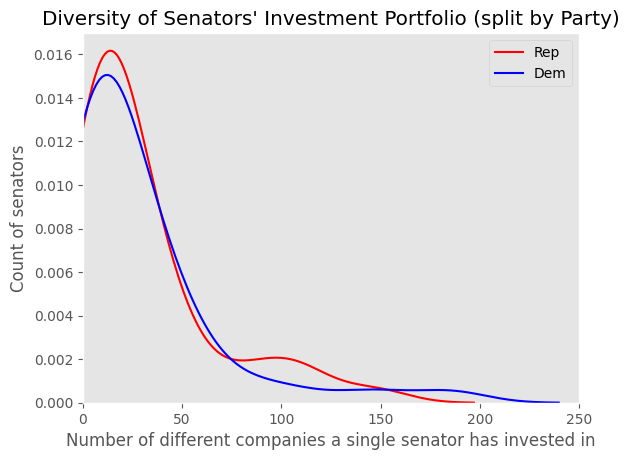

In [13]:
with plt.style.context('ggplot'):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df_senator_count_r = df_senator_count_total[df_senator_count_total["Party"]=="R"]["Count"].reset_index()
        df_senator_count_d = df_senator_count_total[df_senator_count_total["Party"]=="D"]["Count"].reset_index()
        assert not any(np.isinf(df_senator_count_total["Count"]))
        sns.kdeplot(data=df_senator_count_r, x="Count", color="red", label="Rep")#, kind="kde"
        sns.kdeplot(data=df_senator_count_d, x="Count", color="blue", label="Dem")#, kind="kde"
    plt.legend()
    plt.grid(False)
    plt.xlim(0, 250)
    plt.title("Diversity of Senators' Investment Portfolio (split by Party)")
    plt.xlabel("Number of different companies a single senator has invested in")
    plt.ylabel('Count of senators')
    plt.show()
    plt.close()

## Stanford CA Analysis

### How does time variation matter?

In [14]:
datetime_cols = ["cld_fic_filing_dt", "cld_fic_class_start_dt", "cld_fic_class_end_dt", "case_last_stage_date"]
df_lawsuits[datetime_cols] = df_lawsuits[datetime_cols].astype("datetime64[ms]")

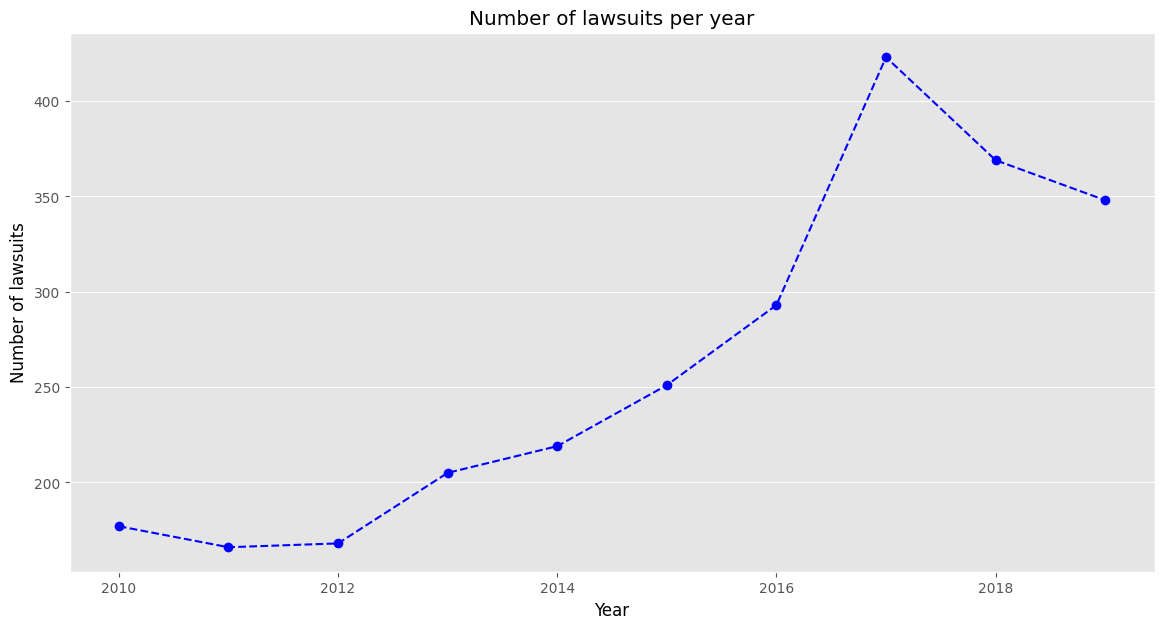

In [15]:
df_case_per_time = df_lawsuits[["index_number", "cld_case_status_gen_luv", "cld_fic_class_start_dt"]]
df_case_per_time = df_case_per_time.dropna()
df_case_per_time["year"] = df_case_per_time["cld_fic_class_start_dt"].dt.year
df_case_per_year_grouped = df_case_per_time.groupby("year")["index_number"].count().reset_index().sort_values("year", ascending=True)
with plt.style.context("ggplot"):
    plt.figure(figsize=(14, 7))
    plt.plot(df_case_per_year_grouped["year"][:-1], df_case_per_year_grouped["index_number"][:-1], linestyle="--", marker="o", color="blue")
    plt.title("Number of lawsuits per year")
    plt.xlabel("Year", color="black")
    plt.ylabel("Number of lawsuits", color="black")
    plt.grid(False)
    ax = plt.gca()
    ax.yaxis.grid(True)
    plt.show()
    plt.close()

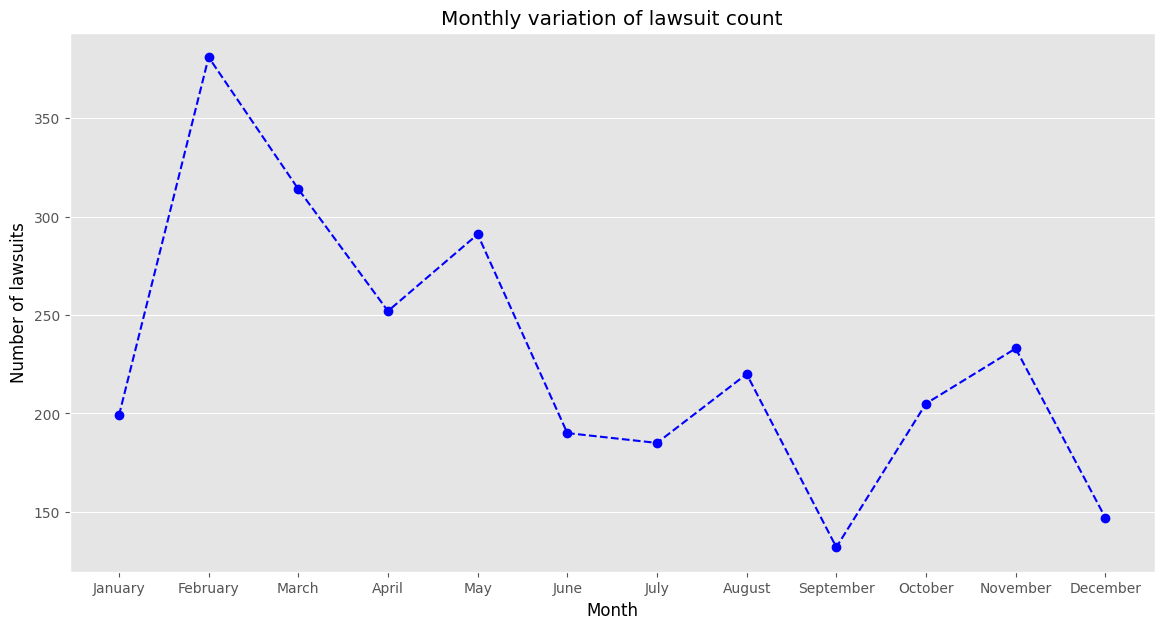

In [16]:
df_case_per_time["month"] = df_case_per_time["cld_fic_class_start_dt"].dt.month
df_case_per_month_grouped = df_case_per_time.groupby("month")["index_number"].count().reset_index().sort_values("month", ascending=True)
with plt.style.context("ggplot"):
    plt.figure(figsize=(14, 7))
    plt.plot(df_case_per_month_grouped["month"], df_case_per_month_grouped["index_number"], linestyle="--", marker="o", color="blue")
    plt.title("Monthly variation of lawsuit count")
    plt.xlabel("Month", color="black")
    plt.ylabel("Number of lawsuits", color="black")
    plt.grid(False)
    ax = plt.gca()
    ax.yaxis.grid(True)
    plt.xticks(range(1, 13))
    ax.set_xticklabels([calendar.month_name[month_index] for month_index in range(1, 13)])
    plt.show()
    plt.close()

View categories of companies with class action lawsuits.

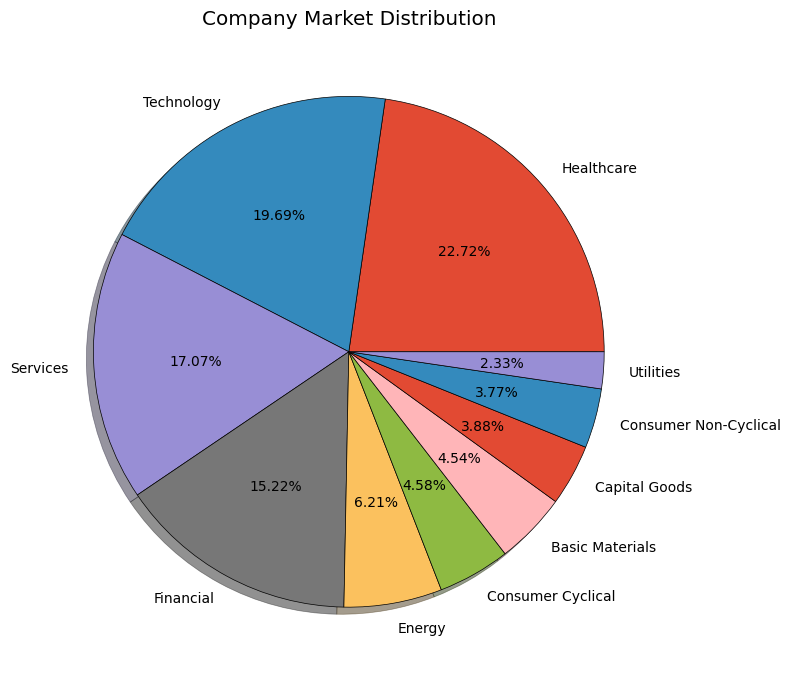

In [17]:
market_counts = df_lawsuits["comp_classification_sector_luv"].value_counts(normalize=True) * 100

# Filter for significant categories (optional)
filtered_data = market_counts[market_counts > 2]
filtered_labels = filtered_data.index

# Plot the pie chart
with plt.style.context("ggplot"):
    plt.figure(figsize=(8, 8))
    plt.pie(
        filtered_data,
        labels=filtered_labels,
        wedgeprops={"edgecolor": "black"},
        autopct="%1.2f%%",
        shadow=True
    )
    plt.title("Company Market Distribution")
    plt.tight_layout()
    plt.show()
plt.close()

What are the companies with the most class action lawsuits?

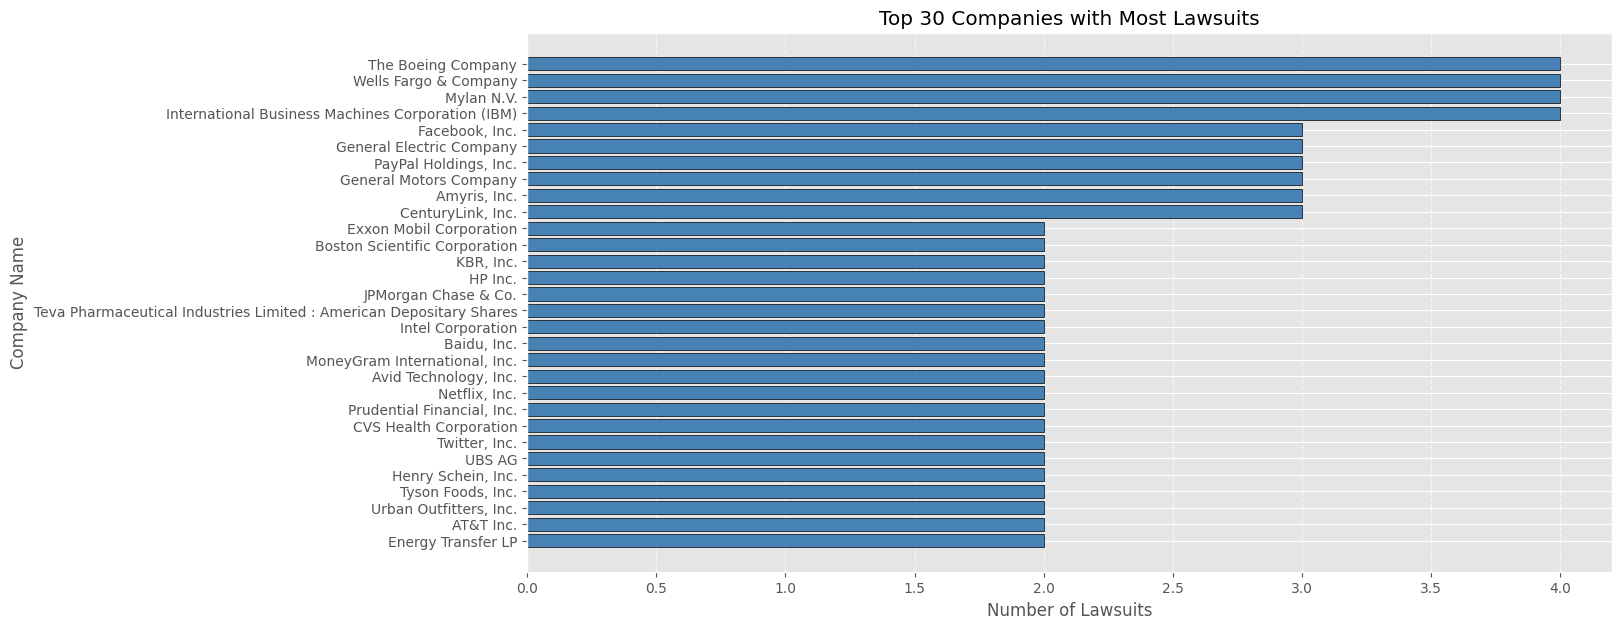

In [18]:
company_list = set(df["Symbol"])
filtered_lawsuits = df_lawsuits[df_lawsuits["company_ticker_symbol"].isin(company_list)]
lawsuit_counts = filtered_lawsuits["composite_litigation_name"].value_counts()

top_n = 30  # Adjust as needed
lawsuit_counts = lawsuit_counts.head(top_n)

# Plot the bar chart
with plt.style.context("ggplot"):
    plt.figure(figsize=(14, 7))
    plt.barh(lawsuit_counts.index[::-1], lawsuit_counts.values[::-1],
             color="steelblue", edgecolor="black")
    plt.xlabel("Number of Lawsuits")
    plt.ylabel("Company Name")
    plt.title(f"Top {top_n} Companies with Most Lawsuits")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()
plt.close()

Are settlements/dismissals more or less likely when senators have holdings?

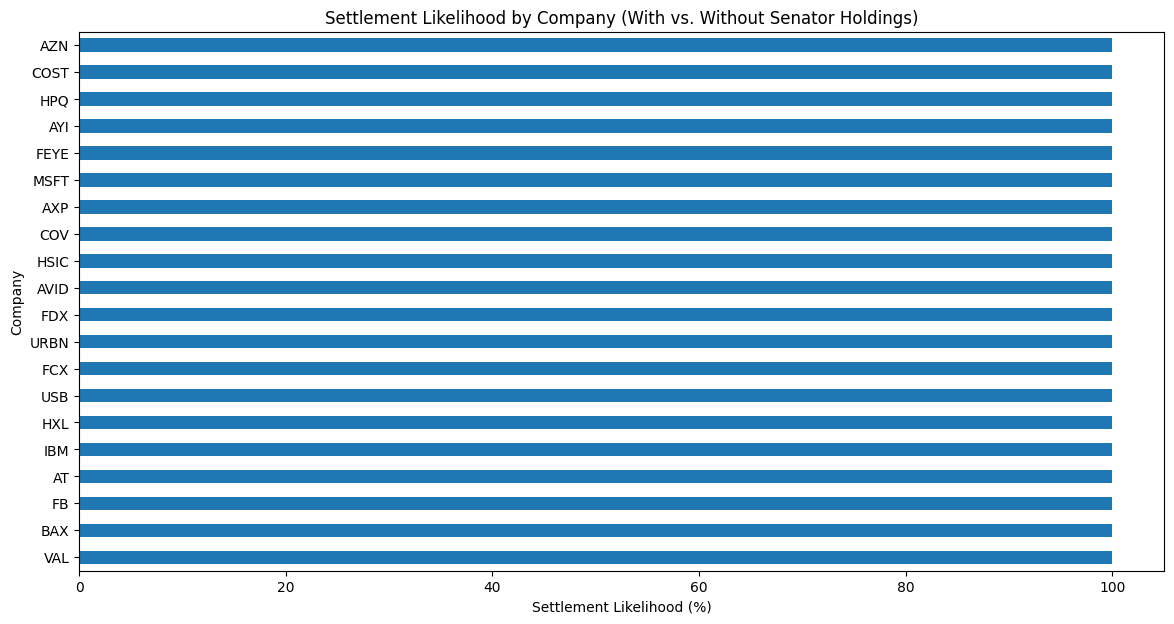

In [19]:
df['has_senator_holdings'] = df['Estimated Holdings'] > 0
settlement_dismissal_df = df_lawsuits[df_lawsuits['cld_case_status_gen_luv'].isin(['CASE SETTLED', 'CASE DISMISSED'])].copy()
companies_with_holdings = set(df[df['has_senator_holdings']]['Symbol'])
settlement_dismissal_df.loc[:, 'has_senator_holdings'] = settlement_dismissal_df['company_ticker_symbol'].isin(companies_with_holdings)
# Group by ticker symbol, count cases
company_lawsuit_counts = settlement_dismissal_df.groupby(['company_ticker_symbol', 'has_senator_holdings'])['composite_litigation_name'].count().unstack().fillna(0)
# Calculate the likelihood of settlement or dismissal
company_lawsuit_counts['settlement_likelihood'] = (company_lawsuit_counts[True] / (company_lawsuit_counts[True] + company_lawsuit_counts[False])) * 100

top_companies = company_lawsuit_counts.sort_values(by='settlement_likelihood', ascending=False).head(20)

# Plot the settlement likelihood for the top 20 companies
top_companies['settlement_likelihood'].plot(kind='barh', figsize=(14, 7))
plt.title('Settlement Likelihood by Company (With vs. Without Senator Holdings)')
plt.xlabel('Settlement Likelihood (%)')
plt.ylabel('Company')
plt.show()

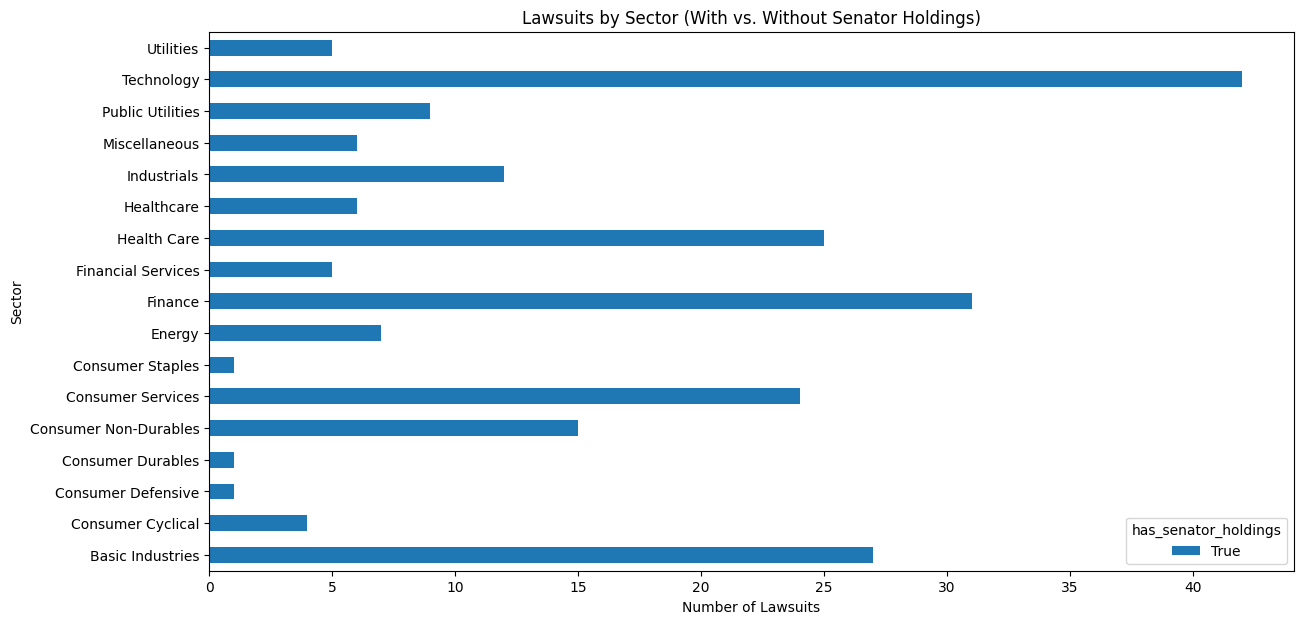

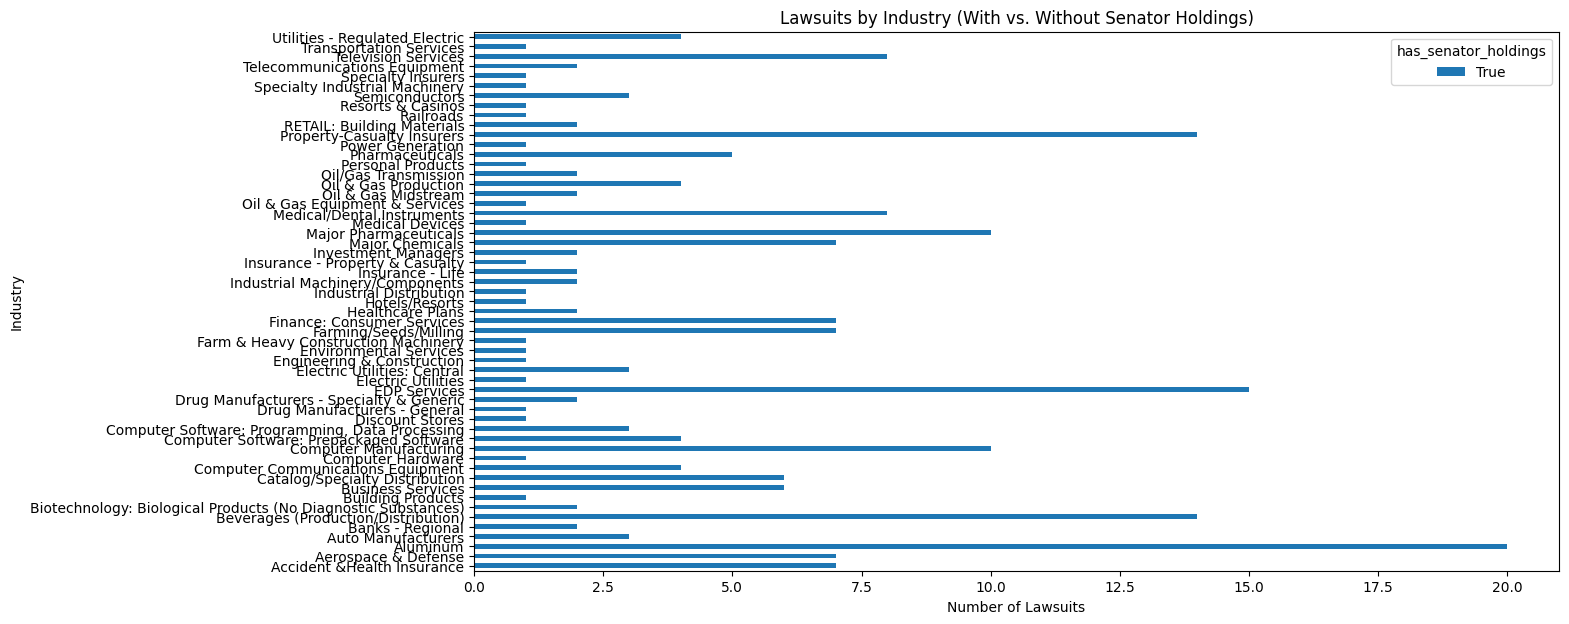

In [20]:
settlement_dismissal_df.loc[:, 'has_senator_holdings'] = settlement_dismissal_df['company_ticker_symbol'].isin(companies_with_holdings)

sector_mapping = df.set_index('Symbol')['Sector'].to_dict()
industry_mapping = df.set_index('Symbol')['Industry'].to_dict()

settlement_dismissal_df['Sector']   = settlement_dismissal_df['company_ticker_symbol'].map(sector_mapping)
settlement_dismissal_df['Industry'] = settlement_dismissal_df['company_ticker_symbol'].map(industry_mapping)

# Group by sector
sector_lawsuit_counts = settlement_dismissal_df.groupby(['Sector', 'has_senator_holdings'])['composite_litigation_name'].count().unstack(fill_value=0)

# Group by industry
industry_lawsuit_counts = settlement_dismissal_df.groupby(['Industry', 'has_senator_holdings'])['composite_litigation_name'].count().unstack(fill_value=0)

# Number of lawsuits by sector
sector_lawsuit_counts.plot(kind='barh', stacked=True, figsize=(14, 7))
plt.title('Lawsuits by Sector (With vs. Without Senator Holdings)')
plt.xlabel('Number of Lawsuits')
plt.ylabel('Sector')
plt.show()

# Number of lawsuits by industry
industry_lawsuit_counts.plot(kind='barh', stacked=True, figsize=(14, 7))
plt.title('Lawsuits by Industry (With vs. Without Senator Holdings)')
plt.xlabel('Number of Lawsuits')
plt.ylabel('Industry')
plt.show()

Trend over time

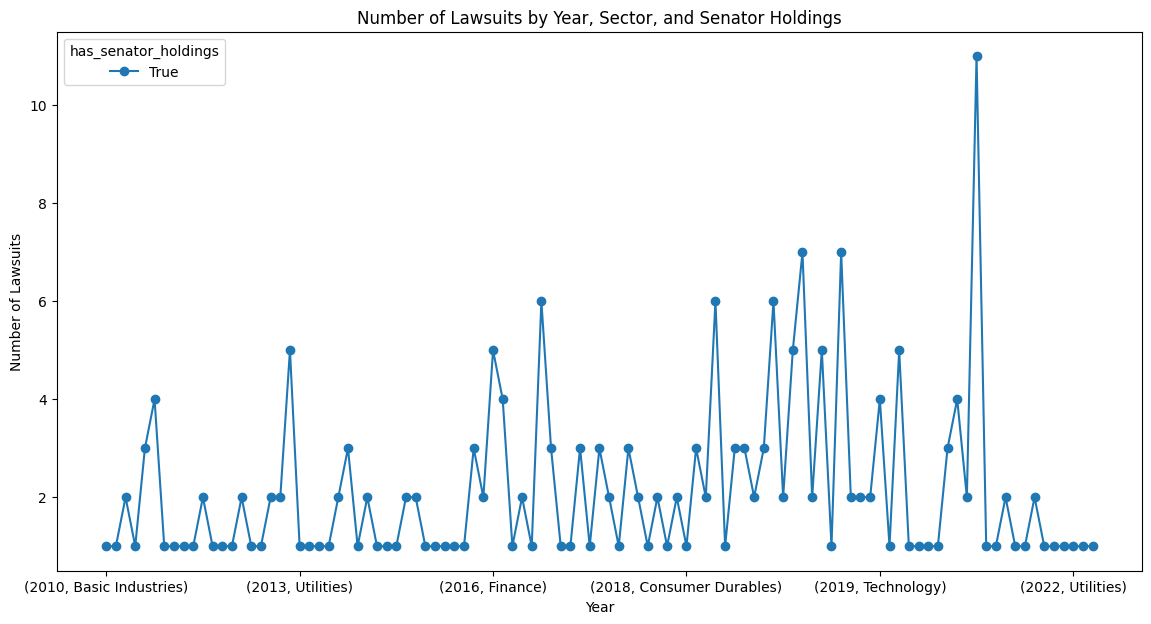

In [21]:
settlement_dismissal_df['cld_fic_filing_dt'] = pd.to_datetime(settlement_dismissal_df['cld_fic_filing_dt'])

settlement_dismissal_df['year'] = settlement_dismissal_df['cld_fic_filing_dt'].dt.year

yearly_lawsuit_counts = settlement_dismissal_df.groupby(['year', 'Sector', 'has_senator_holdings']).size().unstack(fill_value=0)

yearly_lawsuit_counts.plot(kind='line', figsize=(14, 7), marker='o')
plt.title('Number of Lawsuits by Year, Sector, and Senator Holdings')
plt.xlabel('Year')
plt.ylabel('Number of Lawsuits')
plt.show()

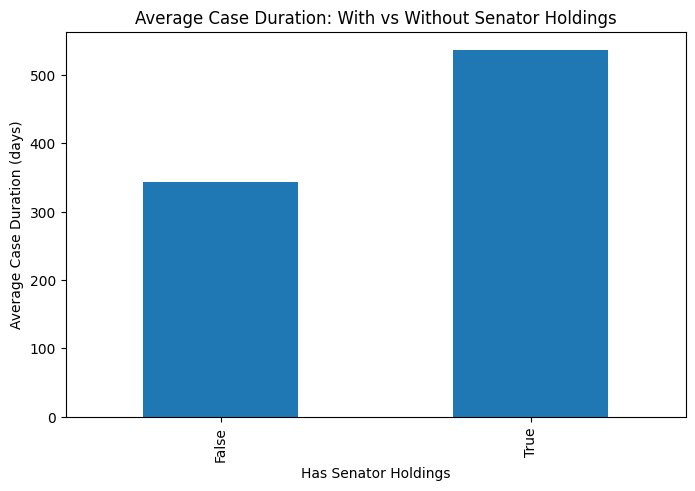

In [22]:
# Duration of lawsuits
settlement_dismissal_df['case_duration'] = (pd.to_datetime(settlement_dismissal_df['cld_fic_class_end_dt']) -
                                             pd.to_datetime(settlement_dismissal_df['cld_fic_class_start_dt'])).dt.days

avg_case_duration = settlement_dismissal_df.groupby('has_senator_holdings')['case_duration'].mean()

avg_case_duration.plot(kind='bar', figsize=(8, 5))
plt.title('Average Case Duration: With vs Without Senator Holdings')
plt.xlabel('Has Senator Holdings')
plt.ylabel('Average Case Duration (days)')
plt.show()

### Do senators divest/invest in companies that settle suits more than go to trial?

In [23]:
df_combined["Party"].value_counts()

,count
Party,
R,463
D,347


<Figure size 1400x700 with 0 Axes>

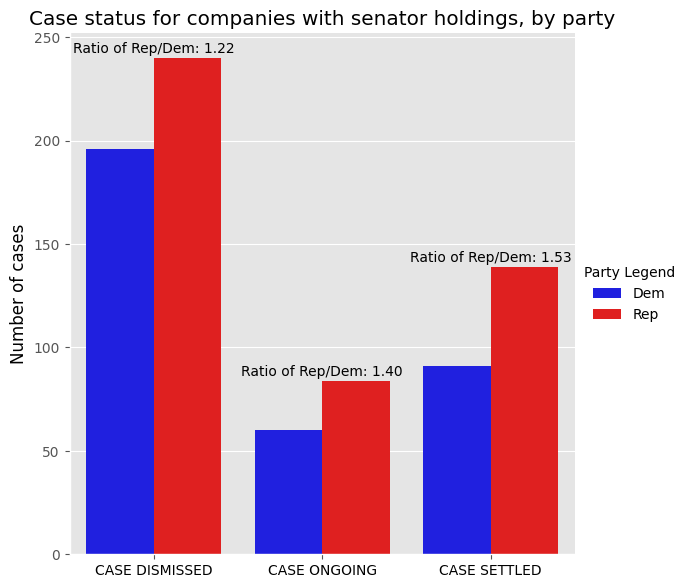

In [24]:
df_partycasestatus = df_combined.groupby(["Party", "cld_case_status_gen_luv"])["index_number"].count().reset_index()
df_partycasestatus["Party Legend"] = ""
df_partycasestatus.loc[df_partycasestatus["Party"]=="R", "Party Legend"] = "Rep"
df_partycasestatus.loc[df_partycasestatus["Party"]=="D", "Party Legend"] = "Dem"

with plt.style.context("ggplot"):
    plt.figure(figsize=(14, 7))
    sns.catplot(
        data=df_partycasestatus, kind="bar",
        x="cld_case_status_gen_luv", y="index_number", hue="Party Legend",
        errorbar="sd", palette=sns.color_palette(['blue', 'red']), alpha=1, height=6)
    ax = plt.gca()
    for i in range(3):
        bar1 = ax.patches[i]
        bar2 = ax.patches[i + 3]
        h1 = bar1.get_height()
        h2 = bar2.get_height()
        diff = h2/h1
        x = (bar1.get_x() + bar2.get_x()) / 2 + bar1.get_width() / 2
        y = max(bar1.get_height(), bar2.get_height()) + 1
        ax.text(x, y, f'Ratio of Rep/Dem: {diff:.2f}', ha='center', va='bottom', color='black')
    ax.set(xlabel=None)
    plt.xticks(color="black")
    plt.title("Case status for companies with senator holdings, by party")
    plt.ylabel("Number of cases", color="Black")
    plt.show()
plt.close()

In [25]:
for status in df_partycasestatus.cld_case_status_gen_luv.unique():
    total = np.sum(df_partycasestatus[df_partycasestatus["cld_case_status_gen_luv"]==status]["index_number"])
    new = pd.DataFrame({"Party": ["c"], "cld_case_status_gen_luv": [status],
                     "index_number": [total], "Party Legend":["Combined"]})
    df_partycasestatus = pd.concat([df_partycasestatus,new])

<Figure size 1400x500 with 0 Axes>

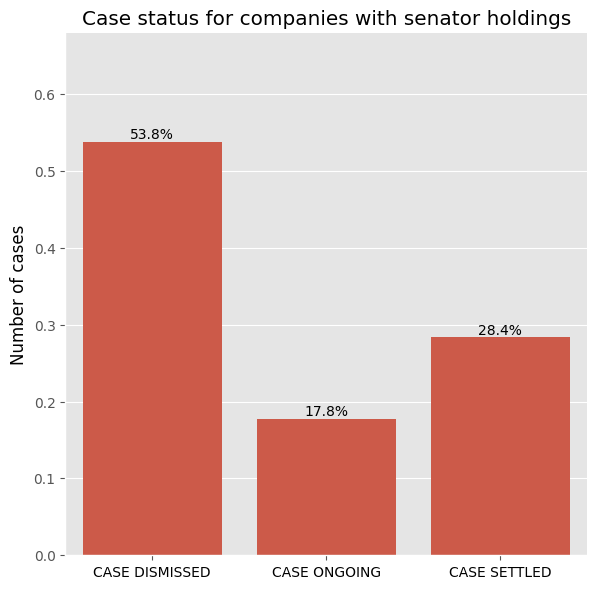

In [26]:
total = np.sum(df_partycasestatus[df_partycasestatus["Party"]=="c"]["index_number"])

with plt.style.context("ggplot"):
    plt.figure(figsize=(14, 5))
    sns.catplot(kind="bar",
                x=df_partycasestatus[df_partycasestatus.Party=="c"]["cld_case_status_gen_luv"],
                y=df_partycasestatus[df_partycasestatus.Party=="c"]["index_number"]/total,
                errorbar=None, alpha=1, height=6)
    ax = plt.gca()
    ax.set(xlabel=None)
    for i in range(3):
        bar1 = ax.patches[i]
        y = bar1.get_height()
        x = bar1.get_x() + bar1.get_width() / 2
        ax.text(x, y, f'{y*100:.1f}%', ha='center', va='bottom', color='black')
    plt.xticks(color="black")
    plt.ylabel("Number of cases", color="Black")
    plt.ylim([0,0.68])
    plt.title("Case status for companies with senator holdings")
    plt.show()
plt.close()

<Figure size 1400x500 with 0 Axes>

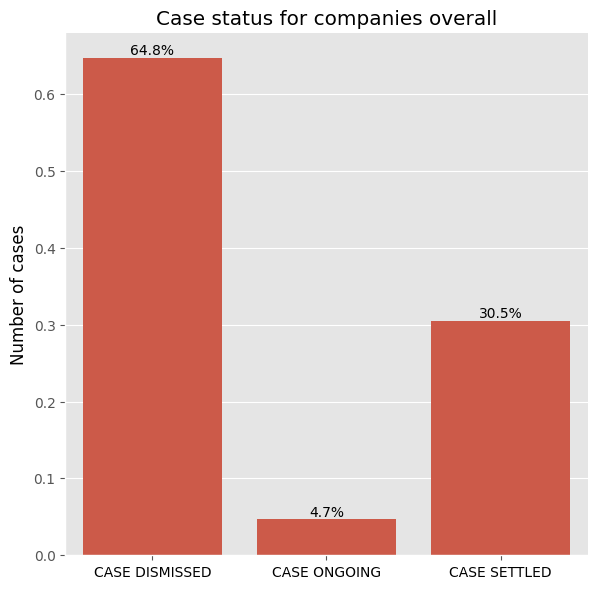

In [27]:
dismissal_counts = df_lawsuits["cld_case_status_gen_luv"].value_counts()[:-1]
dismissal_counts /= np.sum(dismissal_counts)
dismissal_counts.iloc[[1,2]] = dismissal_counts.iloc[[2,1]]
with plt.style.context("ggplot"):
    plt.figure(figsize=(14, 5))
    sns.catplot(kind="bar",
                x=dismissal_counts.index[[0,2,1]], y=dismissal_counts,
                errorbar=None, alpha=1, height=6)
    ax = plt.gca()
    ax.set(xlabel=None)
    for i in range(3):
        bar1 = ax.patches[i]
        y = bar1.get_height()
        x = bar1.get_x() + bar1.get_width() / 2
        ax.text(x, y, f'{y*100:.1f}%', ha='center', va='bottom', color='black')
    plt.xticks(color="black")
    plt.ylabel("Number of cases", color="Black")
    plt.title("Case status for companies overall")
    plt.ylim([0,0.68])
    plt.show()
plt.close()

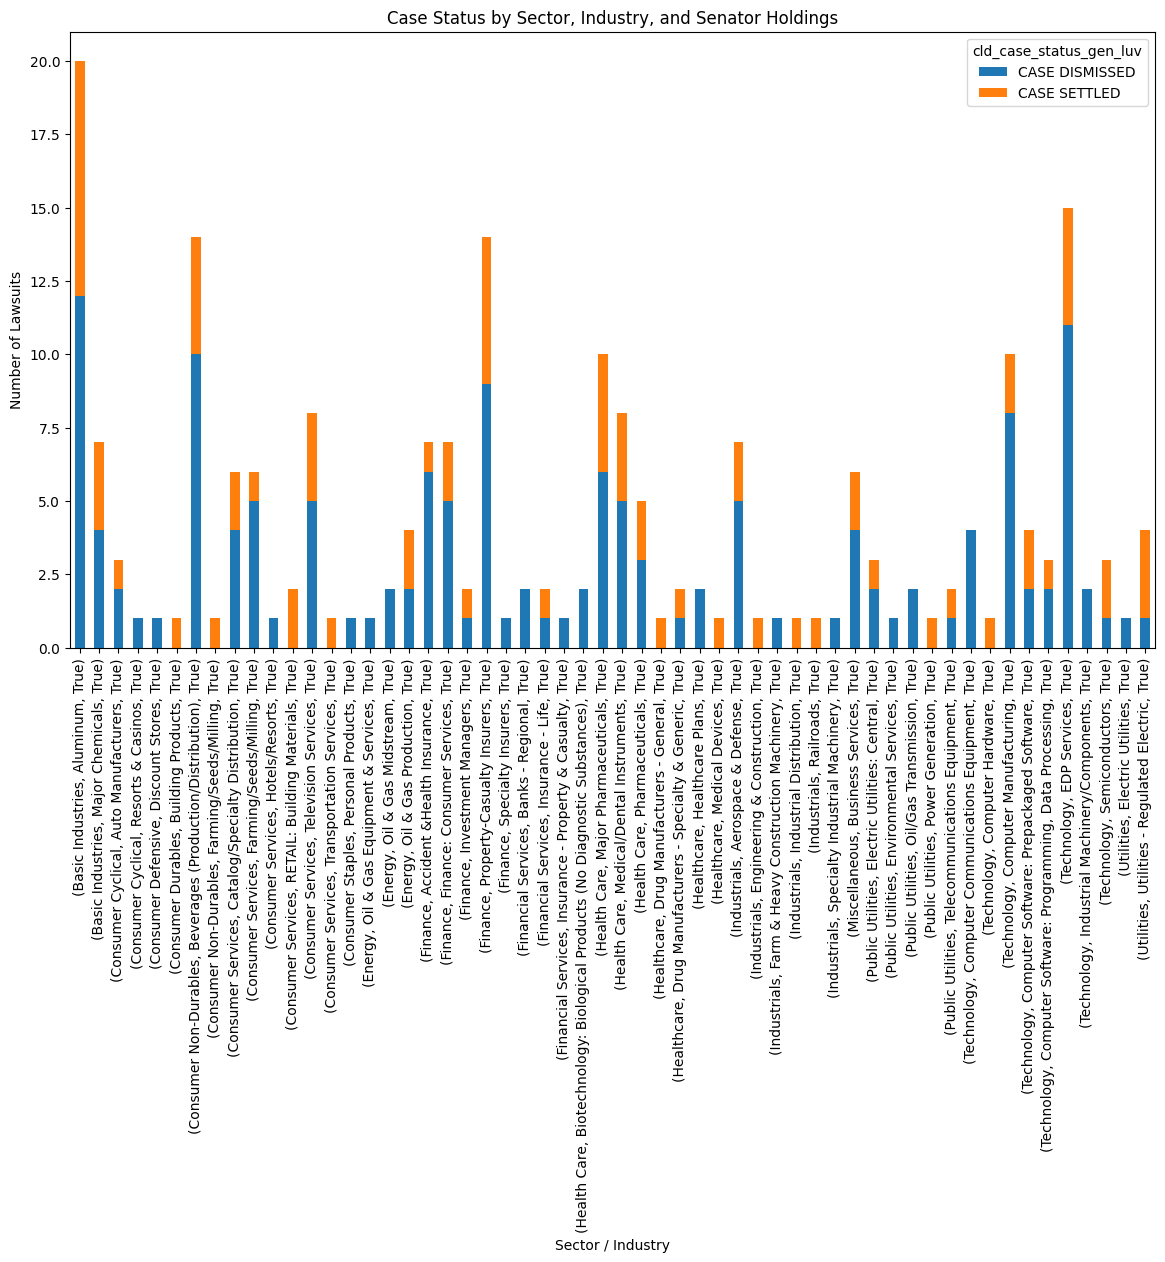

In [28]:
lawsuit_type_by_sector_industry = settlement_dismissal_df.groupby(['Sector', 'Industry', 'has_senator_holdings', 'cld_case_status_gen_luv']).size().unstack(fill_value=0)

lawsuit_type_by_sector_industry.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Case Status by Sector, Industry, and Senator Holdings')
plt.xlabel('Sector / Industry')
plt.ylabel('Number of Lawsuits')
plt.show()

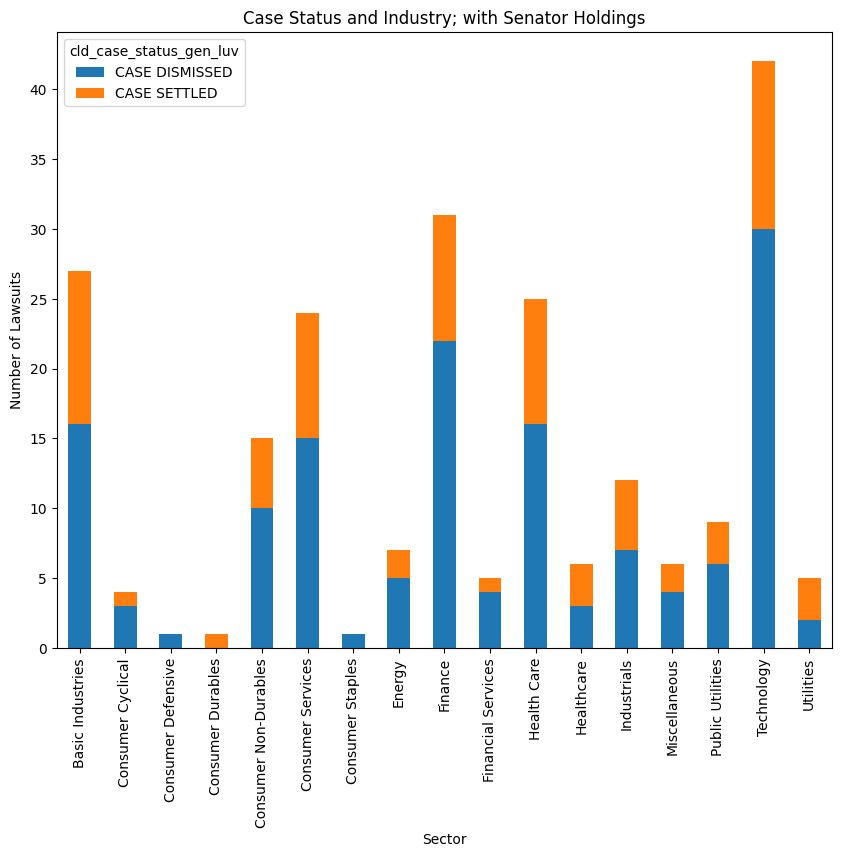

In [29]:
lawsuit_type_by_sector = settlement_dismissal_df.groupby(['Sector', 'cld_case_status_gen_luv']).size().unstack(fill_value=0)

lawsuit_type_by_sector.plot(kind='bar', stacked=True, figsize=(10, 8))
plt.title('Case Status and Industry; with Senator Holdings')
plt.xlabel('Sector')
plt.ylabel('Number of Lawsuits')
plt.show()

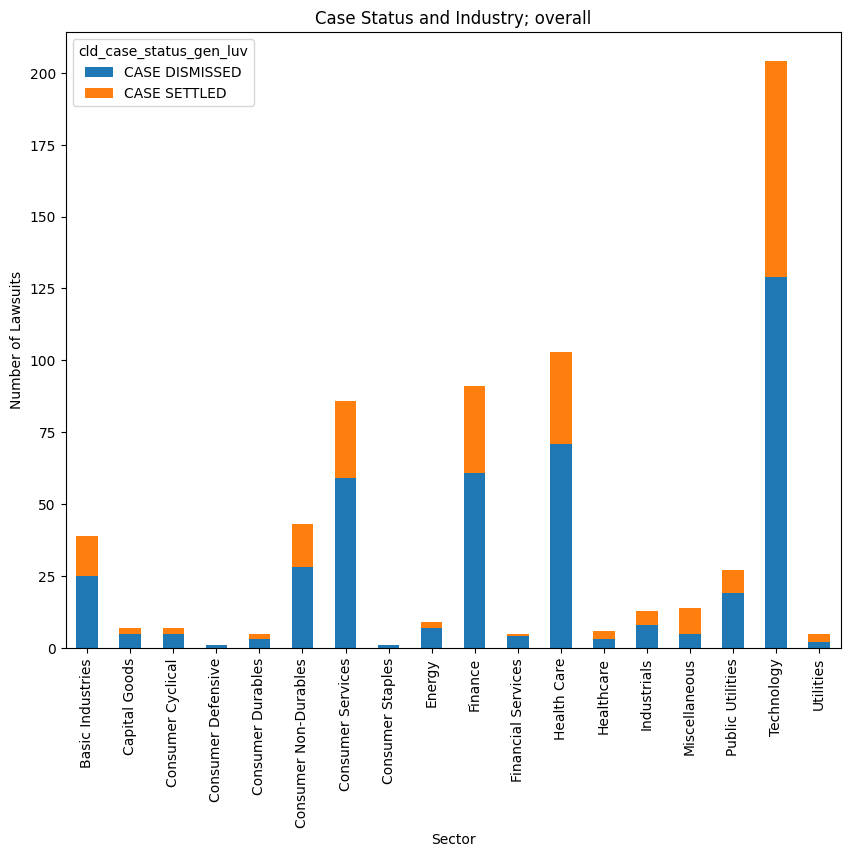

In [30]:
lawsuit_type_by_sector2 = df_combined.groupby(['Sector', 'cld_case_status_gen_luv']).size().unstack(fill_value=0)
# lawsuit_type_by_sector2 = df_lawsuits.groupby(['comp_classification_sector_luv', 'cld_case_status_gen_luv']).size().unstack(fill_value=0)
lawsuit_type_by_sector2 = lawsuit_type_by_sector2[["CASE DISMISSED","CASE SETTLED"]]
lawsuit_type_by_sector2.plot(kind='bar', stacked=True, figsize=(10, 8))
plt.title('Case Status and Industry; overall')
plt.xlabel('Sector')
plt.ylabel('Number of Lawsuits')
plt.show()

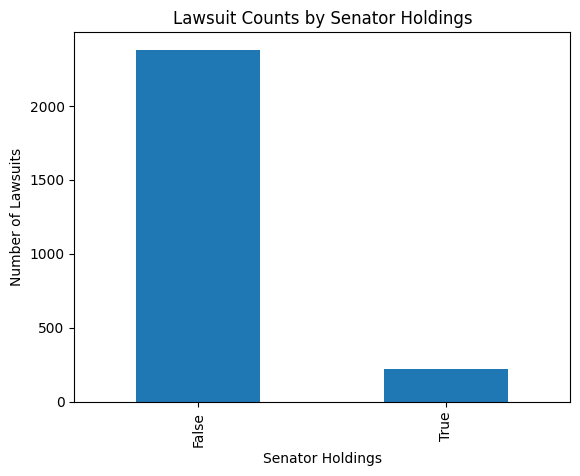

In [31]:
lawsuit_count_by_holdings = settlement_dismissal_df.groupby('has_senator_holdings')['composite_litigation_name'].count()

lawsuit_count_by_holdings.plot(kind='bar')
plt.title('Lawsuit Counts by Senator Holdings')
plt.xlabel('Senator Holdings')
plt.ylabel('Number of Lawsuits')
plt.show()